# Ungraded Lab: Training a binary classifier with the Sarcasm Dataset

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) from last week and proceed to build a train a model on it. The steps will be very similar to the previous lab with IMDB Reviews with just some minor modifications. You can tweak the hyperparameters and see how it affects the results. Let's begin!

## Imports

In [5]:
import json
import io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Process the dataset

You can download the dataset with the code below. Here it was already downloaded for you so the code in the next cell is commented out.

In [6]:
# Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

The dataset is saved as a JSON file. Load it into your workspace and put the sentences and labels into lists.

In [7]:
# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Parameters

The parameters are placed in the cell below so you can easily tweak them later:

In [8]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Output dimensions of the Embedding layer
EMBEDDING_DIM = 16

## Split the dataset

Next, you will generate your train and test datasets. You will use the `training_size` value you set above to slice the `sentences` and `labels` lists into two sublists: one for training and another for testing.

In [9]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

## Preprocessing the train and test sets

As usual, you will generate a `TextVectorization` layer based on the training inputs.

In [10]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_LENGTH)

# Generate the vocabulary based on the training inputs
vectorize_layer.adapt(train_sentences)

Unlike the previous lab (i.e. IMDB reviews), the data you're using here is not yet a `tf.data.Dataset` but a list. Thus, you can pass it directly to the `vectorize_layer` as shown below. As shown in the Week 1 labs, this will output post-padded sequences.

In [11]:
# Apply the vectorization layer on the train and test inputs
train_sequences = vectorize_layer(train_sentences)
test_sequences = vectorize_layer(test_sentences)

Now you will combine the inputs and labels into a `tf.data.Dataset` to prepare it for training.

In [12]:
# Combine input-output pairs for training
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences,train_labels))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences,test_labels))

You can view a few examples as a sanity check.

In [13]:
# View 2 examples
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 319,    1,  943, 4079, 2366,   47,  366,   94, 2026,    6, 2653,
       9470,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)

(<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([   4, 7185, 3128, 3305,   28,    2,  152,    1,  358, 2902,    6,
        236,    9,  844,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)



Then, you will optimize and batch the datasets.

In [14]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

## Build and Compile the Model

Next, you will build the model. The architecture is similar to the previous lab but you will use a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays (i.e. `(10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [15]:
# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4. 2.]]


This added computation reduces the dimensionality of the model as compared to using `Flatten()` and thus, the number of training parameters will also decrease. See the output of `model.summary()` below and see how it compares if you swap out the pooling layer with a simple `Flatten()`.

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,433 (626.69 KB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

You will use the same loss, optimizer, and metrics from the previous lab.

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Train the Model

Now you will feed in the prepared datasets to train the model. If you used the default hyperparameters, you will get around 99% training accuracy and 80% validation accuracy.

*Tip: You can set the `verbose` parameter of `model.fit()` to `2` to indicate that you want to print just the results per epoch. Setting it to `1` (default) displays a progress bar per epoch, while `0` silences all displays. It doesn't matter much in this Colab but when working in a production environment, you may want to set this to `2` as recommended in the [documentation](https://keras.io/api/models/model_training_apis/#fit-method).*

In [18]:
num_epochs = 10

# Train the model
history = model.fit(train_dataset_final, epochs=num_epochs, validation_data=test_dataset_final, verbose=2)

Epoch 1/10
625/625 - 3s - 4ms/step - accuracy: 0.6736 - loss: 0.6003 - val_accuracy: 0.8015 - val_loss: 0.4494
Epoch 2/10
625/625 - 2s - 3ms/step - accuracy: 0.8469 - loss: 0.3668 - val_accuracy: 0.8451 - val_loss: 0.3669
Epoch 3/10
625/625 - 2s - 3ms/step - accuracy: 0.8842 - loss: 0.2877 - val_accuracy: 0.8511 - val_loss: 0.3509
Epoch 4/10
625/625 - 2s - 3ms/step - accuracy: 0.9061 - loss: 0.2381 - val_accuracy: 0.8504 - val_loss: 0.3487
Epoch 5/10
625/625 - 2s - 3ms/step - accuracy: 0.9240 - loss: 0.2017 - val_accuracy: 0.8512 - val_loss: 0.3596
Epoch 6/10
625/625 - 2s - 3ms/step - accuracy: 0.9328 - loss: 0.1788 - val_accuracy: 0.8523 - val_loss: 0.3775
Epoch 7/10
625/625 - 2s - 3ms/step - accuracy: 0.9426 - loss: 0.1572 - val_accuracy: 0.8386 - val_loss: 0.4160
Epoch 8/10
625/625 - 2s - 3ms/step - accuracy: 0.9510 - loss: 0.1389 - val_accuracy: 0.8490 - val_loss: 0.4191
Epoch 9/10
625/625 - 2s - 3ms/step - accuracy: 0.9569 - loss: 0.1236 - val_accuracy: 0.8447 - val_loss: 0.4478
E

## Visualize the Results

You can use the cell below to plot the training results. You may notice some overfitting because your validation accuracy is slowly dropping while the training accuracy is still going up. See if you can improve it by tweaking the hyperparameters. Some example values are shown in the lectures.

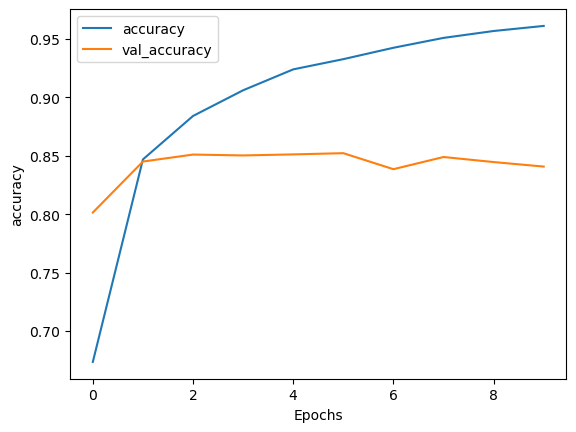

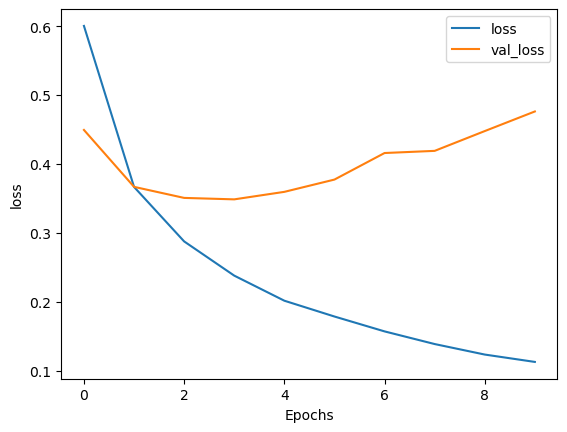

In [19]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Visualize Word Embeddings

As before, you can visualize the final weights of the embeddings using the [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

In [20]:
# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


In [21]:
# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Get the word list
vocabulary = vectorize_layer.get_vocabulary()

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, len(vocabulary)):

  # Get the word associated with the current index
  word_name = vocabulary[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

## Wrap Up

In this lab, you were able to build a binary classifier to detect sarcasm. You saw some overfitting in the initial attempt and hopefully, you were able to arrive at a better set of hyperparameters.

So far, you've been tokenizing datasets from scratch and you're treating the vocab size as a hyperparameter. Furthermore, you're tokenizing the texts by building a vocabulary of full words. In the next lab, you will make use of a pre-tokenized dataset that uses a vocabulary of *subwords*. For instance, instead of having a unique token for the word `Tensorflow`, it will instead have a token each for `Ten`, `sor`, and `flow`. You will see the motivation and implications of having this design in the next exercise. See you there!